# Исследование данных о продажах компьютерных игр

В нашем распоряжении исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Открыть файл с данными и изучить общую информацию.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# отключать при необходимости
import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузка данных
df = pd.read_csv('games.csv')

In [4]:
display(df.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные корректно прочитаны из файла, будем дальше углубляться в анализ и выведем основную информацию о датафрейме с помощью метода info()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


У нас данные, состоящие из 16715 строк и 11 столбцов. Можем сразу отметить, что данные по столбцам как: `Year_of_Release, User_Score, Rating` и т.д, заполнены не в полном объеме, присутствуют пропуски. Наименования столбцов не записаны в одном регистре. Тип данных в столбце Year_of_Release определен как `float64`, что странно, так как в столбце данные о годах выпуска игры. Тип данных User_Score столбца `object`, но логика подсказывать, что тип данных должен быть c плавающей точкой.

## Предобработка данных.

### Заменим названия столбцов (приведем к нижнему регистру).

In [6]:
df = df.rename(str.lower, axis = 'columns')

In [7]:
#проверим
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков.

In [8]:
# посчитаем долю пропусков в каждом столбце относительно общего объема данных
df.isna().sum()/df.shape[0]*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

#### name & genre & year_of_release

Пропуски по столбцам `name, genre и year_of_release` можем удалить, так как доля пропусков по этим столбцам около 1.6% и это действие не скажется на анализе.

In [9]:
df = df.dropna(subset=['name']).reset_index(drop=True)
df = df.dropna(subset=['genre']).reset_index(drop=True)
df = df.dropna(subset=['year_of_release']).reset_index(drop=True)

#### critic_score & user_score

In [10]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

В столбце — critic_score — содержатся данные с оценками критиков от 0 до 100. Считаем, что необходимо оставить данные пропуски как неизвестные значения. Если мы заполним эти пропуски 0, это будет некорректно, так как 0 это тоже оценка. Средним или медианным значением тоже не представляется возможным, так как это все исказит дальнейший анализ, а учитывая что пропусков больше 10% это сильно повлияет на анализ. 

#### user_score

In [11]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце — user_score — данные с оценкой пользователей от 0 до 10. Исходя из той же логики, что с оценками критиков, считаем необходимым оставить пропуски в данном столбце. В данных присутствуют так же значение как "tdb" это означает, что оценка отсутствует, считаем необходимым заменить такие значения на `Nan`, что будет означать одно и тоже, но присутствует данных типа `Nan` позволит нам в дальнейшем анализировать этот столбец.

In [12]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

#### rating

В столбце — rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Пропуски в данном столбце считаем возможным заполнить категориальным значением `Unknown`, потому что не представляется возможным заполнить возрастным рейтингом, если он не определен.

In [13]:
df['rating'] = df['rating'].fillna('Unknown')

In [14]:
df['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

### Обработка дубликатов.

In [15]:
# проверим датасет на наличие явных дубликатов
df.duplicated().sum()

0

Явных дубликатов не обнаружено.

### Преобразование типа данных.

Как мы отмечали выше необходимо поменять тип данных по столбцу `year_of_release`, чтобы данные были целочисленными, а так же по столбцу `user_score` поменяем тип данных с `object` на `float`, так данные с оценкой пользователей от 0 до 10 с плавающей точкой. 

In [16]:
# преобразуем данные из столбца year_of_release
df['year_of_release'] = df['year_of_release'].astype('int')

# преобразуем данные из столбца user_score
df['user_score'] = df['user_score'].astype('float')

Проверим что получилось

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


Как мы видим пропуски убраны, тип данных изменен в соответствующих столбцах.

### Cуммарные продажи во всех регионах.

Создадим столбец `sales_amount` и запишем в нем сумму продаж во всех регионах.

In [18]:
df['sales_amount'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [19]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  sales_amount     16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных.

### Сколько игр выпускалось в разные годы. 

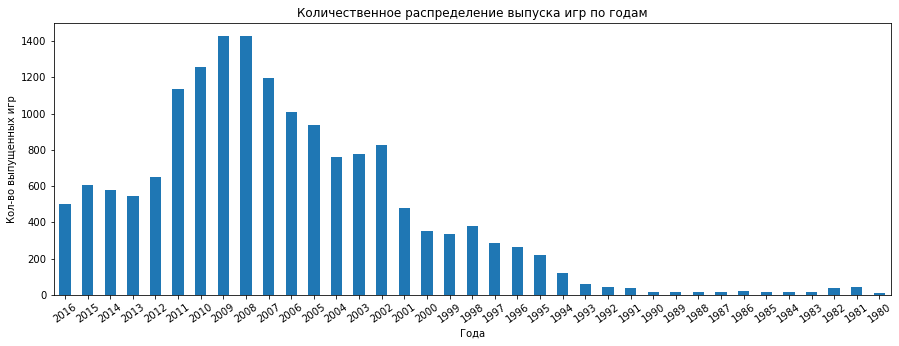

In [20]:
#строим график
df['year_of_release'].value_counts()\
                     .sort_index(ascending=False)\
                     .plot(kind='bar' ,figsize=(15,5))\
                     .set(title='Количественное распределение выпуска игр по годам', 
                          xlabel = 'Года', 
                          ylabel='Кол-во выпущенных игр');
plt.xticks(rotation=35);

Можем отметить, что рост gamedeva начинается с 90-х годов. В период с 1980 по 1994 данных по выпуску игр относительно остального времени мало.

### Как менялись продажи по платформам.

Определим платформы с наибольшими суммарными продажами.

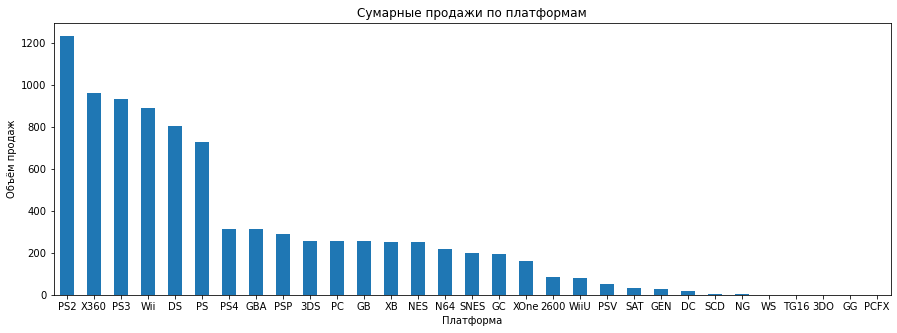

In [21]:
df.pivot_table(index=('platform'), values='sales_amount', aggfunc=['sum'])\
    .sort_values(by=('sum', 'sales_amount'), ascending=False)\
    .plot(kind='bar', figsize=(15,5), legend=False, rot=0)\
    .set(title='Сумарные продажи по платформам', xlabel = 'Платформа', ylabel='Объём продаж');

Можем выделить 6 платформ лидеров по продажам: `PS2, X360, PS3, Wii, DS, PS`. Посмотрим распределение продаж по годам данных платформ.

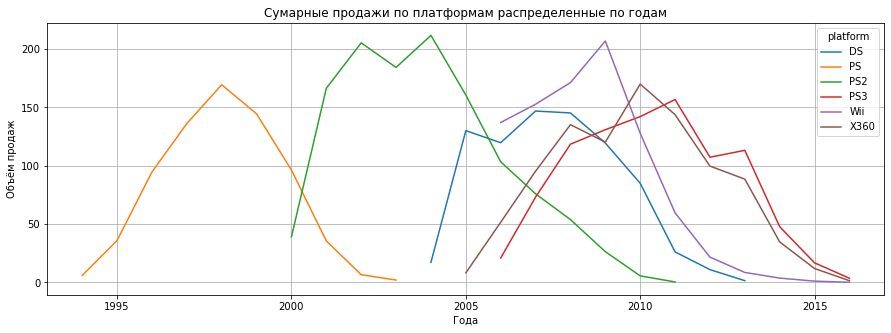

In [22]:
#в новую переменную запишем данные по топ 6 платформам
top_platform = df.query('platform == "PS2" | platform == "X360" | platform == "PS3" | platform == "Wii" | platform == "DS" | platform == "PS"')
#построим распределение
top_platform_sales = top_platform.pivot_table(index='year_of_release', 
                                              values='sales_amount', 
                                              columns='platform', 
                                              aggfunc='sum')\
.plot(grid=True, figsize=(15, 5))\
.set(title='Сумарные продажи по платформам распределенные по годам', xlabel = 'Года', ylabel='Объём продаж')
plt.xlim(1993, 2017);


Так же можем отметить по графику, что цикл жизни у современных платформ +- 10 лет. Необходимо более точно разобраться.

Проведем расчеты для точного анализа срока жизни современных платформ.

In [23]:
# по топу платформ создадим сводную таблицу убрав дубликаты по соответствующим столбцам
# это даст нам понимание сколько лет выходят игры на те или иные платформы
platform_life_cycle = top_platform.loc[:,['year_of_release', 'platform']]\
        .drop_duplicates()\
        .pivot_table(index=['platform'], values='year_of_release', aggfunc='count')
display(platform_life_cycle)

,year_of_release
platform,
DS,11
PS,10
PS2,12
PS3,11
Wii,11
X360,12


In [24]:
# посмотрим на основные характеристики полученных значений
display(platform_life_cycle.describe())

,year_of_release
count,6.000000
mean,11.166667
std,0.752773
min,10.000000
25%,11.000000
50%,11.000000
75%,11.750000
max,12.000000


Как мы и отмечали, средний цикл жизни современных платформ 11 лет.

### Актуальный период для прогноза на 2017 год.

Считаем необходимым выбрать период для анализа 4 года. Исходя из следующего:
- Отрасль разработки игр быстро развивается. Данные быстро становятся неактуальными.
- Жизненный цикл платформ лидеров рынка находится на спаде. Игровые платформы являются конкурентными товарами по отношению друг к другу, к концу жизненного цикла, к чему судя по нашему анализу рынок идет, выйдет новое поколение платформ.
- Новые платформы, это новые технологические возможности для разработки игр. (данные старше нескольких лет не подойдут)

### Лидеры по продажам.

Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [25]:
# Отсечем данные за актуальный период
top_actual_platforms = df.query('year_of_release >= 2012')

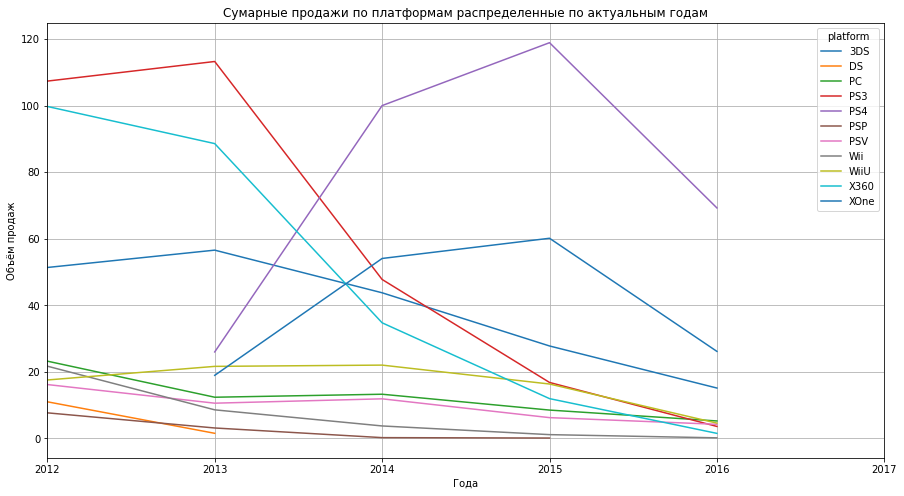

In [26]:
# построим график продаж с этими платформами
top_actual_platforms_sales = top_actual_platforms.pivot_table(index='year_of_release', 
                                              values='sales_amount', 
                                              columns='platform', 
                                              aggfunc='sum')\
.plot(grid=True, figsize=(15, 8))\
.set(title='Сумарные продажи по платформам распределенные по актуальным годам', xlabel = 'Года', ylabel='Объём продаж')
plt.xlim(2012, 2017);

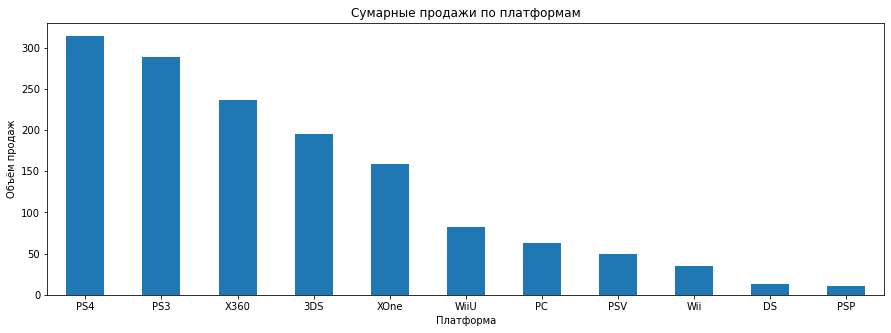

In [27]:
# посмотрим на сумарные продажи на другом графике для наглядности
top_actual_platforms.pivot_table(index='platform', values='sales_amount', aggfunc=['sum'])\
    .sort_values(by=('sum', 'sales_amount'), ascending=False)\
    .plot(kind='bar', figsize=(15,5), legend=False, rot=0)\
    .set(title='Сумарные продажи по платформам', xlabel = 'Платформа', ylabel='Объём продаж');

Можем отметить, что в целом по отрасли наблюдается падение продаж. Есть две новые платформы нового поколения от мастодонтов отрасли SONY `PS4` и Microsoft `XOne`. Отдельно стоит отметить платформу `PC` (personal computer), хоть продажи на данной платформе не такие высокие как на игровых приставках, но эта платформа не имеет определенного поколения и жизненного цикла, обусловлено это тем, что персональный компьютер состоит из сборных частей так называемого железа, которые можно заменить при необходимости, тогда как на игровых приставках такой возможности нет, наблюдается жесткий цикл жизни платформ определенного поколения. У игровых приставок существует ограничения в виде совместимости игр, которые вышли на те или иные поколения, не говоря уже про разные платформы, персональный компьютер лишен таких ограничений. Исходя из сказанного считаем необходимым выделить следующие платформы как потенциально прибыльные: `PS4`, `XOne` и `PC`. Остальные платформы из списка находятся на спаде жизненного цикла товара, соответственно считаем, что не стоит их рассматривать как потенциально прибыльные.

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам.

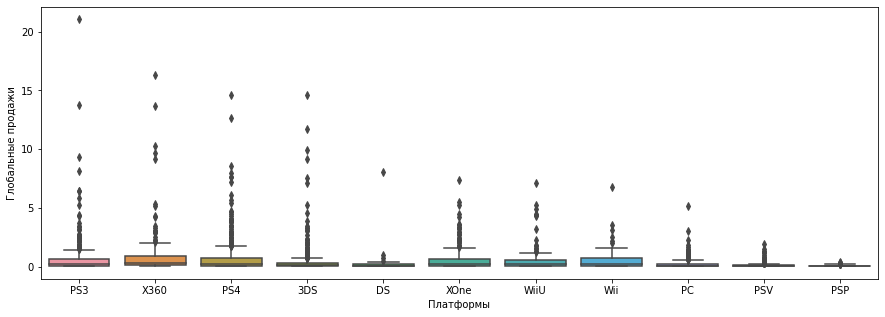

In [28]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=top_actual_platforms, x='platform', y='sales_amount')
plt.xlabel('Платформы')
plt.ylabel('Глобальные продажи');

На данном график, плохо видно медианные и средние значения по продажам, но наглядно может увидеть максимальные выбросы по всем платформам. Скорее всего это единичные хиты.

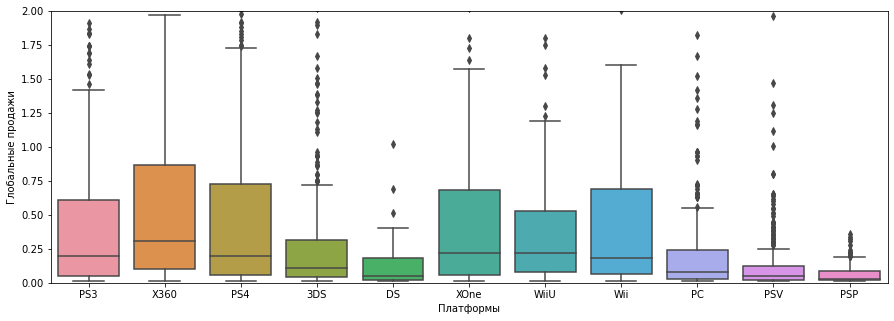

In [29]:
# выведем диаграмму с масштабированными данными  
plt.figure(figsize=(15, 5))
sns.boxplot(data=top_actual_platforms, x='platform', y='sales_amount')
plt.ylim(0, 2,2)
plt.xlabel('Платформы')
plt.ylabel('Глобальные продажи');

Исходя из графиков можем отметить: 
- Медиана протекает у всех по-разному.
- Положение Xbox One и PlayStation 4 можно объяснить тем, что данные приставки позднее остальных вышли на рынки в 2013.
- PC уступает, так как это не узконаправленная платформа только для игр.


### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков.

In [30]:
# выберим платформу PS4
ps4_df = top_actual_platforms.query('platform == "PS4"')

0.40656790206178123

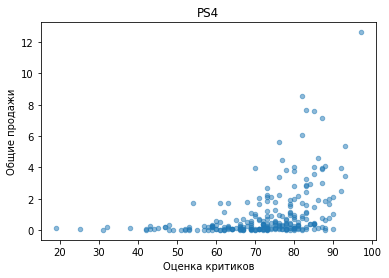

In [31]:
# построим диаграмму рассеяния между оценками критиков и продажами
ps4_df.plot(x='critic_score', y='sales_amount', kind='scatter', alpha=0.5, figsize=(6, 4)).set(title = 'PS4',
                                                                                           xlabel = 'Оценка критиков',
                                                                                           ylabel = 'Общие продажи');

# посчитаем корреляцию между оценками критиков и продажами
display(ps4_df['critic_score'].corr(ps4_df['sales_amount']))

Коэффициент корреляции Пирсона равен 0.41. Существует прямая средняя линейная связь продаж с оценками критиков.

-0.03195711020455644

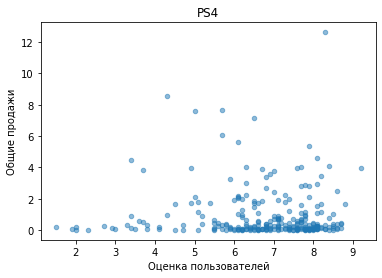

In [32]:
# построим диаграмму рассеяния между оценками пользователей и продажами
ps4_df.plot(x='user_score', y='sales_amount', kind='scatter', alpha=0.5, figsize=(6, 4)).set(title = 'PS4',
                                                                                           xlabel = 'Оценка пользователей',
                                                                                           ylabel = 'Общие продажи');

# посчитаем корреляцию между оценками пользователей и продажами
display(ps4_df['user_score'].corr(ps4_df['sales_amount']))

Исходя из коэффициента корреляции Пирсона равному -0.032 и диаграммы рассеяния отметим, что оценки пользователей корреляции с продажами не имеют. 

### Соотнесите выводы с продажами игр на других платформах за актуальный период.

In [33]:
# цикл который в зависимости от платформы посчитает корреляцию
for platform in ['PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC']:
    print('\n{0}:'.format(platform))
    #for column in ['user_score', 'critic_score']:
    platform_df = top_actual_platforms.query('platform == @platform')
    critic_corr = platform_df['critic_score'].corr(platform_df['sales_amount'])
    user_corr = platform_df['user_score'].corr(platform_df['sales_amount'])
    if critic_corr < 0.1:
        print(f'Коэффициент Пирсона равен {critic_corr}. Оценки критиков с продажами связи не имеют')
    elif 0.3 >= critic_corr >= 0.1:
        print(f'Коэффициент Пирсона равен {critic_corr}. Оценки критиков имеют слабую связь с продажами')
    elif 0.5 >= critic_corr >= 0.3:
        print(f'Коэффициент Пирсона равен {critic_corr}. Оценки критиков имеют умеренную связь с продажами')
    elif 0.7 >= critic_corr >= 0.5:
        print(f'Коэффициент Пирсона равен {critic_corr}. Оценки критиков имеют довольно сильную связь с продажами')
    elif critic_corr >= 0.7:
        print(f'Коэффициент Пирсона равен {critic_corr}. Оценки критиков имеют очень сильную связь с продажами')
            
    if user_corr < 0.1:
        print(f'Коэффициент Пирсона равен {user_corr}. Оценки игроков с продажами связи не имеют')
    elif 0.3 >= user_corr >= 0.1:
        print(f'Коэффициент Пирсона равен {user_corr}. Оценки игроков имеют слабую связь с продажами')
    elif 0.5 >= user_corr >= 0.3:
        print(f'Коэффициент Пирсона равен {user_corr}. Оценки игроков имеют умеренную связь с продажами')
    elif 0.7 >= user_corr >= 0.5:
        print(f'Коэффициент Пирсона равен {user_corr}. Оценки игроков имеют довольно сильную связь с продажами')
    elif user_corr >= 0.7:
        print(f'Коэффициент Пирсона равен {user_corr}. Оценки игроков имеют очень сильную связь с продажами')       


PS3:
Коэффициент Пирсона равен 0.33149725926295903. Оценки критиков имеют умеренную связь с продажами
Коэффициент Пирсона равен -0.005143522887113829. Оценки игроков с продажами связи не имеют

XOne:
Коэффициент Пирсона равен 0.41699832800840153. Оценки критиков имеют умеренную связь с продажами
Коэффициент Пирсона равен -0.06892505328279418. Оценки игроков с продажами связи не имеют

3DS:
Коэффициент Пирсона равен 0.3208028695360785. Оценки критиков имеют умеренную связь с продажами
Коэффициент Пирсона равен 0.19758263411038593. Оценки игроков имеют слабую связь с продажами

X360:
Коэффициент Пирсона равен 0.36057348885073387. Оценки критиков имеют умеренную связь с продажами
Коэффициент Пирсона равен 0.006163978646213359. Оценки игроков с продажами связи не имеют

WiiU:
Коэффициент Пирсона равен 0.34837976012017496. Оценки критиков имеют умеренную связь с продажами
Коэффициент Пирсона равен 0.40021902021486194. Оценки игроков имеют умеренную связь с продажами

PC:
Коэффициент Пирсон

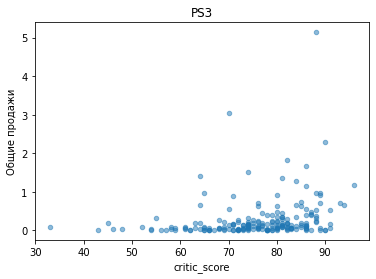

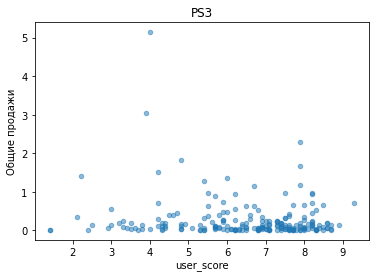

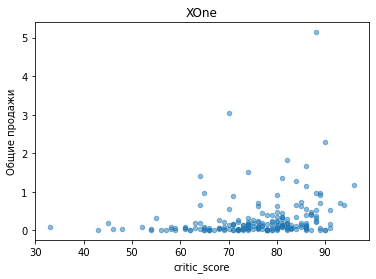

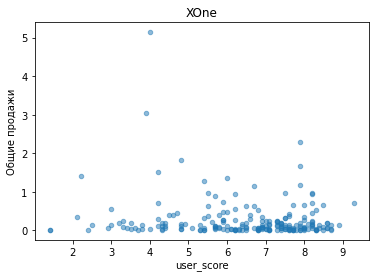

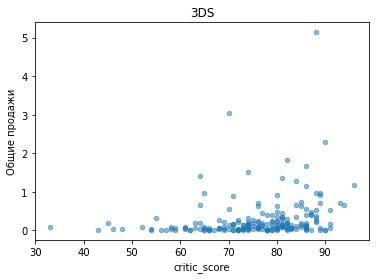

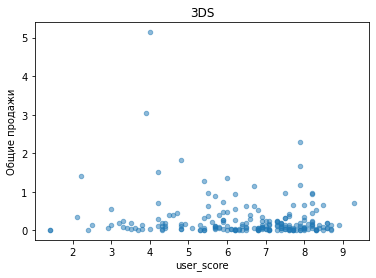

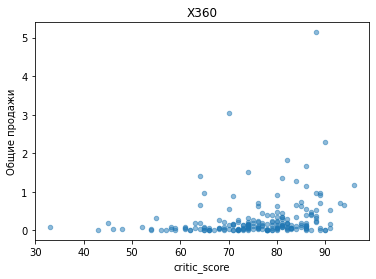

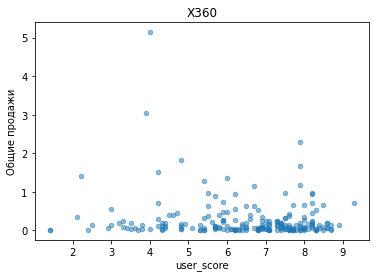

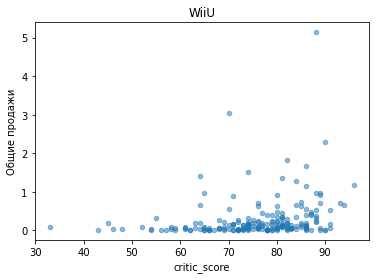

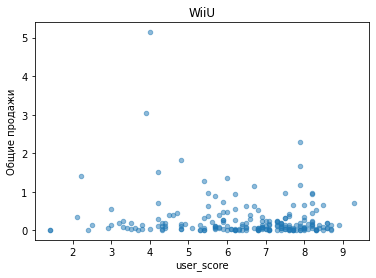

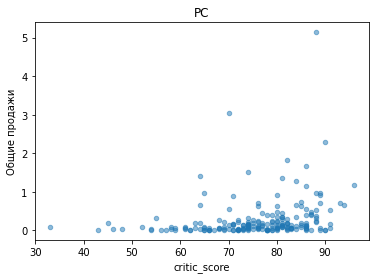

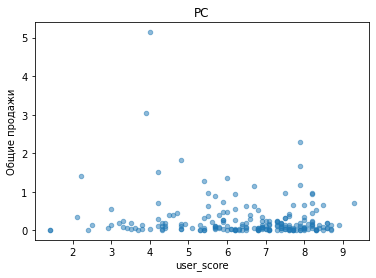

In [34]:
# цикл который в зависимости от платформы построит диаграмму рассеяния
for platform in ['PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC']:
    for column in ['critic_score', 'user_score']:
        platform_df.plot(x=column, y='sales_amount', kind='scatter', alpha=0.5, figsize=(6, 4)).set(title = platform,
                                                                                           xlabel = column,
                                                                                           ylabel = 'Общие продажи');

- Коэффициент Пирсона между продажами игр на актуальных платформах и оценками критиков умеренно положительная - чем выше оценки, тем выше часть продаж. Это подтверждается и нашими графиками рассеяния.
- Коэффициент Пирсона между продажами игр на актуальных платформах и оценками пользователей корреляции не имеют, что и наблюдаем на графиках рассеяния.

### Общее распределение игр по жанрам.

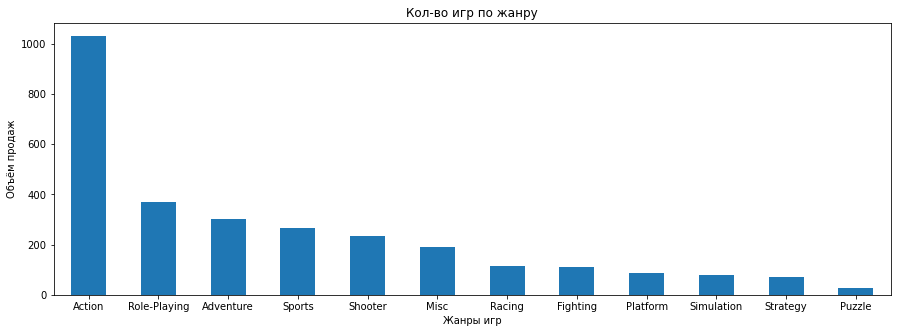

In [35]:
# Узнаем кол-во игр в тех или иных жанрах
top_actual_platforms.pivot_table(index='genre', values='sales_amount', aggfunc=['count'])\
    .sort_values(by=('count', 'sales_amount'), ascending=False)\
    .plot(kind='bar', figsize=(15,5), legend=False, rot=0)\
    .set(title='Кол-во игр по жанру', xlabel = 'Жанры игр', ylabel='Объём продаж');

Больше всего игр выпускаются в жанре `Action`, причем отрыв большой от остальные жанров. Скорее всего это связано с тем, что в этот жанр входят некоторые другие жанры, например `Action-shooter`, `Action-RPG` и так далее.

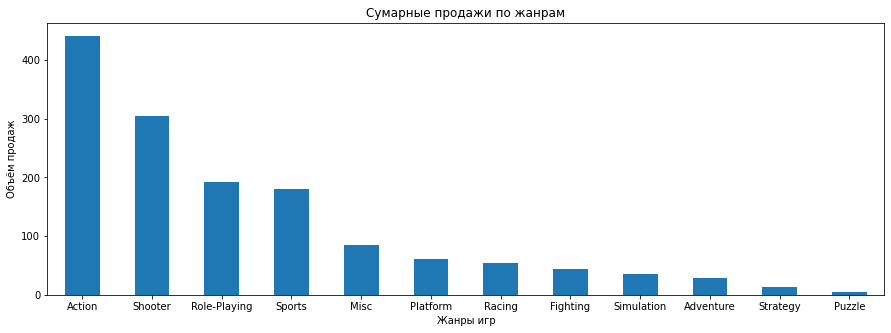

In [36]:
# Рассмотрим распределение по общим продажам
top_actual_platforms.pivot_table(index='genre', values='sales_amount', aggfunc=['sum'])\
    .sort_values(by=('sum', 'sales_amount'), ascending=False)\
    .plot(kind='bar', figsize=(15,5), legend=False, rot=0)\
    .set(title='Сумарные продажи по жанрам', xlabel = 'Жанры игр', ylabel='Объём продаж');

Жанр `Action` самые большие объемы по продажам, но в этом жанре и самое большое кол-во игр, так что не удивительно, что по общим продажам этот жанр лидирует. Жанр `Puzzle` имеет самые низкие общие продажи и самые низкое кол-во выпускаемых игр. 

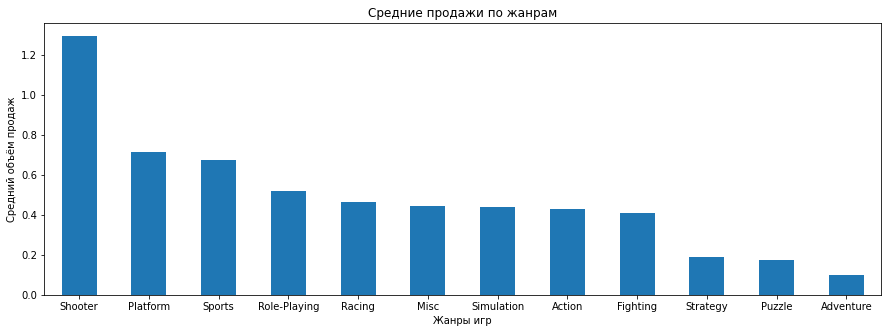

In [37]:
 # Рассмотрим распределение по средним продажам
top_actual_platforms.pivot_table(index='genre', values='sales_amount', aggfunc='mean')\
    .sort_values(by=('sales_amount'), ascending=False)\
    .plot(kind='bar', figsize=(15,5), legend=False, rot=0)\
    .set(title='Средние продажи по жанрам', xlabel = 'Жанры игр', ylabel='Средний объём продаж');

По средним продажам совсем иная картина, теперь мы точно можем отметить, что жанр Shooter является перспективным направлением в gamedev. Лидер по общим продажам Action даже не вошел в топ 5, это говорит о том, что в этом жанре выходит очень много посредственных игр.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5). 

#### NA - Северная Америка

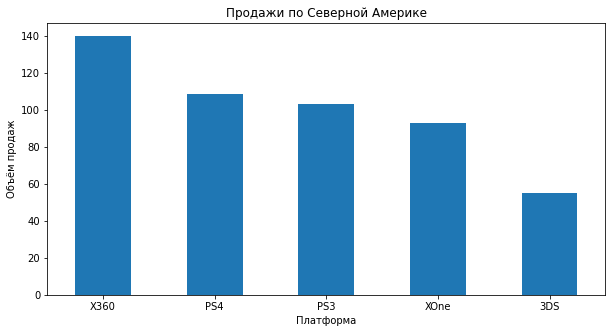

In [38]:
top_actual_platforms.pivot_table(index='platform', values='na_sales', aggfunc='sum')\
    .sort_values(by=('na_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Северной Америке', xlabel = 'Платформа', ylabel='Объём продаж');

Из консолей прошлого поколения лидером по общим продажам в Северной Америке был Xbox 360 больше, чем у прямого конкурента этого же поколения PS3. Другая картина наблюдается среди консолей нового поколения, PS4 обходит по продажам Xbox One.

#### EU - Европа

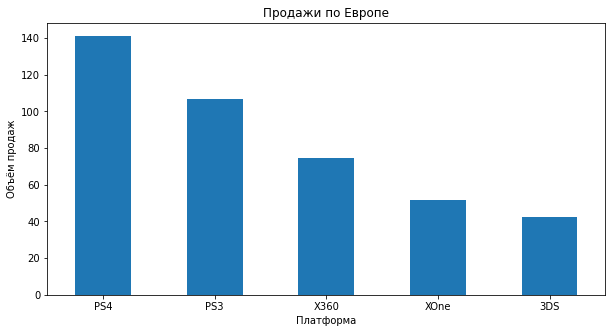

In [39]:
top_actual_platforms.pivot_table(index='platform', values='eu_sales', aggfunc='sum')\
    .sort_values(by=('eu_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Европе', xlabel = 'Платформа', ylabel='Объём продаж');

В Европе игроки любят самураев. PS4 и PS3 занимают первое и второе место соответственно по объемам продаж.

#### JP - Япония

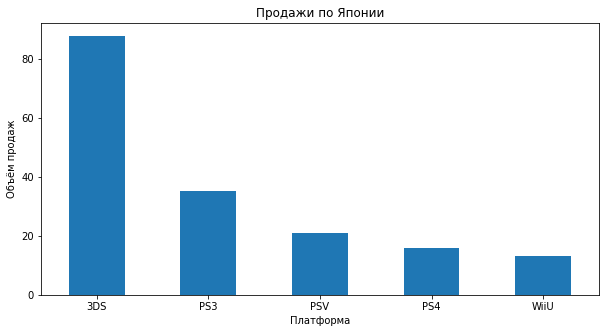

In [40]:
top_actual_platforms.pivot_table(index='platform', values='jp_sales', aggfunc='sum')\
    .sort_values(by=('jp_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Японии', xlabel = 'Платформа', ylabel='Объём продаж');

Интересная картина наблюдается в Японии. Портативная консоль 3DS от Nintendo по объемам продаж обходит такие консоли как PS3 и PS4. Стоит отметить, что так же в топе присутствует другая портативная консоль PSV, в Японии игроки любят играть везде.

Для наглядности какая платформа занимает какую долю рынка в определенном регионе, построим круговую диаграмму.

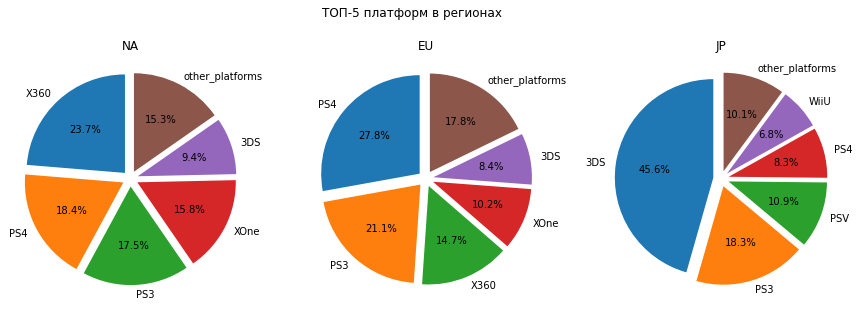

In [41]:
explode = [0.08] * 6 # задаем росстояние между долями круговой диаграммы для наглядности

# Задаем список регионов
countries = top_actual_platforms.columns[4:7]

# Выведим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 платформ в регионах')
# Выберем 5 самых продающих платфор
for i in range(3):
    top_actual_platforms_i = (top_actual_platforms.groupby('platform')[countries[i]].sum().
             reset_index().
             sort_values(countries[i], ascending = False, ignore_index = True).
             head(5))
# Занесем все остальные продажи в other_platforms
    top_actual_platforms_i = top_actual_platforms_i.append({'platform': 'other_platforms', countries[i]: top_actual_platforms[countries[i]].sum() - top_actual_platforms_i[countries[i]].sum()}, ignore_index= True)
    axs[i].pie(top_actual_platforms_i[countries[i]], labels = top_actual_platforms_i['platform'], autopct='%1.1f%%', startangle=90, explode=explode)

# Зададим название региона
    axs[i].set_title(top_actual_platforms_i.columns[1].split('_')[0].upper())
    
plt.show()

- NA, в Северной Америке самая большая доля рынка на текущий момент у платформы Xbox360
- EU, в Европу самая большая доля рынка на текущий момент у платформы PS4
- JP, в Японии самая большая доля рынка на текущий момент у платформы 3DS

### Самые популярные жанры (топ-5). Поясните разницу.

#### NA - Северная Америка

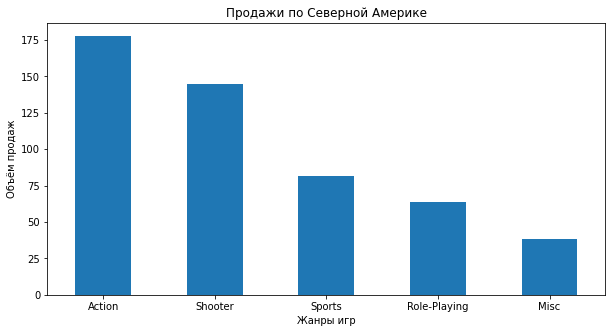

In [42]:
top_actual_platforms.pivot_table(index='genre', values='na_sales', aggfunc='sum')\
    .sort_values(by=('na_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Северной Америке', xlabel = 'Жанры игр', ylabel='Объём продаж');

В Северной Америке по объемам продаж лидирует жанр Action, потом идет Shooter.

#### EU - Европа

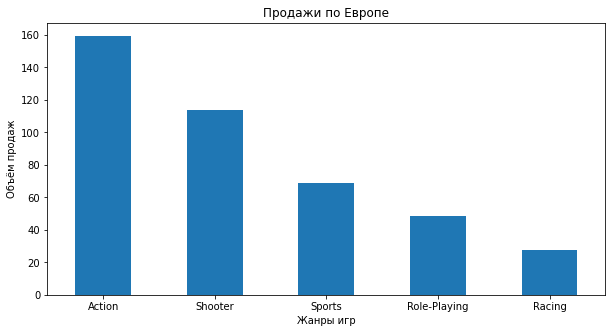

In [43]:
top_actual_platforms.pivot_table(index='genre', values='eu_sales', aggfunc='sum')\
    .sort_values(by=('eu_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Европе', xlabel = 'Жанры игр', ylabel='Объём продаж');

В Европе по популярности жанров идентичная картина, как и в Северной Америке.

#### JP - Япония

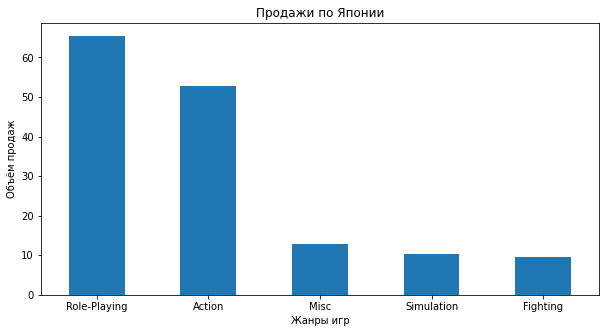

In [44]:
top_actual_platforms.pivot_table(index='genre', values='jp_sales', aggfunc='sum')\
    .sort_values(by=('jp_sales'), ascending=False).head()\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Японии', xlabel = 'Жанры игр', ylabel='Объём продаж');

В Японии, как и в случае с платформами наблюдается совсем другая картина. Больше всего игроки в Японии любят жанр RPG, следом идет Action.

Для наглядности какой жанр занимает какую долю рынка в определенном регионе, построим круговую диаграмму.

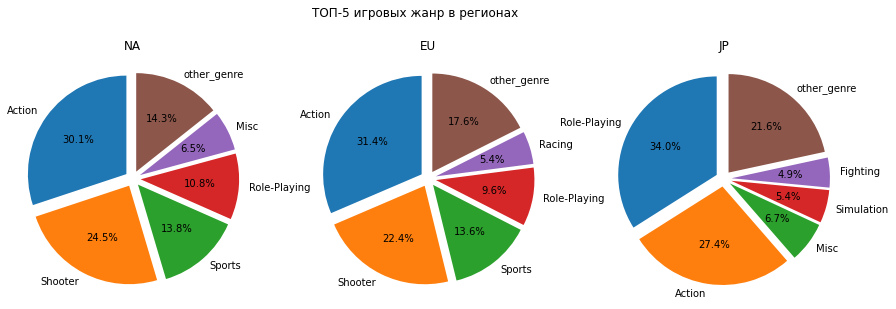

In [45]:
explode = [0.08] * 6

# Задаем список регионов
countries = top_actual_platforms.columns[4:7]

# Выведим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 игровых жанр в регионах')
# Выберем 5 самых актуальных жанров
for i in range(3):
    top_actual_platforms_i = (top_actual_platforms.groupby('genre')[countries[i]].sum().
             reset_index().
             sort_values(countries[i], ascending = False, ignore_index = True).
             head(5))
# Занесем все остальные продажи в other_genre
    top_actual_platforms_i = top_actual_platforms_i.append({'genre': 'other_genre', countries[i]: top_actual_platforms[countries[i]].sum() - top_actual_platforms_i[countries[i]].sum()}, ignore_index= True)
    axs[i].pie(top_actual_platforms_i[countries[i]], labels = top_actual_platforms_i['genre'], autopct='%1.1f%%', startangle=90, explode=explode)

# Зададим название региона
    axs[i].set_title(top_actual_platforms_i.columns[1].split('_')[0].upper())
    
plt.show()

- NA, в Северной Америке самая большая доля рынка на текущий момент у жанра Action
- EU, в Европу самая большая доля рынка на текущий момент у жанра Action
- JP, в Японии самая большая доля рынка на текущий момент у жанра RPG

### Влияние рейтинга ESRB на продажи по регионам.

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. 
- M (Mature) — Для взрослых
- E (everyone) — Для всех
- E10+ (Everyone 10 and older) — Для всех от 10 лет и старше
- T (Teen) — Подросткам

#### NA - Северная Америка

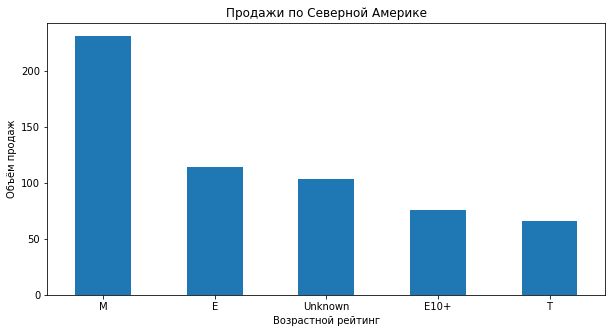

In [46]:
top_actual_platforms.pivot_table(index='rating', values='na_sales', aggfunc='sum')\
    .sort_values(by=('na_sales'), ascending=False)\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Северной Америке', xlabel = 'Возрастной рейтинг', ylabel='Объём продаж');

#### EU - Европа

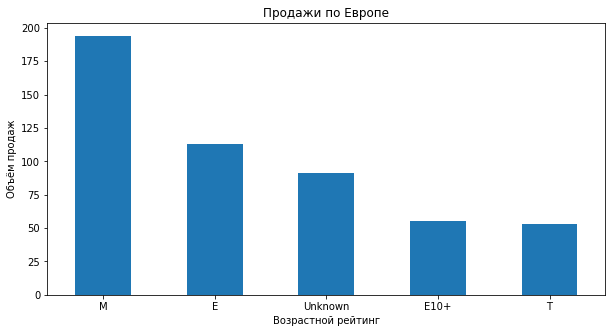

In [47]:
top_actual_platforms.pivot_table(index='rating', values='eu_sales', aggfunc='sum')\
    .sort_values(by=('eu_sales'), ascending=False)\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Европе', xlabel = 'Возрастной рейтинг', ylabel='Объём продаж');

В Европе и в Северной Америке наблюдается идентичная картина. Игры с рейтингом для взрослых имеют самый высокий объем продаж.

#### JP - Япония

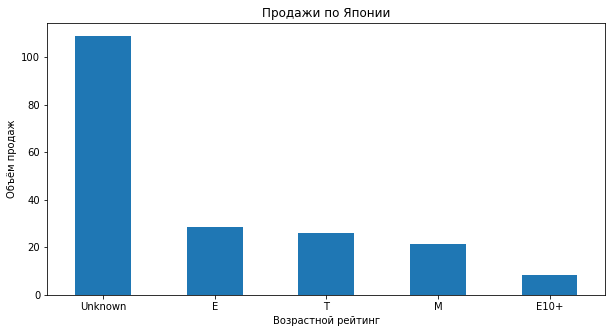

In [48]:
top_actual_platforms.pivot_table(index='rating', values='jp_sales', aggfunc='sum')\
    .sort_values(by=('jp_sales'), ascending=False)\
    .plot(kind='bar', figsize=(10,5), legend=False, rot=0)\
    .set(title='Продажи по Японии', xlabel = 'Возрастной рейтинг', ylabel='Объём продаж');

В Японии игры с возрастным рейтингом для всех имеет самый большой спрос, на втором месте идут игры для подростков.

Портрет пользователя по регионам у нас следующий:
- Северная Америка:
Взрослые, которые любят играть на xbox в action и shooter игры
- Европа:
Взрослые, которые любят играть на playstation в action и shooter игры
- Япония:
Игроки, которые играют портативных консолях типо nintendo в RPG и Action игры для всех.


## Проверка гипотезы

### Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверка гипотезы: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:

- H_0: Средний пользовательский рейтинг по платформе Xbox One = Средний пользовательский рейтинг по платформе PC

- H_1: Средний пользовательский рейтинг по платформе Xbox One ≠ Средний пользовательский рейтинг по платформе PC

alpha = 0.05 

In [49]:
# так как проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам 
# будем использовать ttest_ind

results = st.ttest_ind(
    top_actual_platforms.query('platform == "XOne" & user_score > 0')['user_score'],
    top_actual_platforms.query('platform == "PC" & user_score > 0')['user_score'],
    equal_var = False
)

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Не получилось отвергнуть нулевую гипотезу, можно сделать вывод, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые**.

In [50]:
top_actual_platforms.query('platform == "XOne" or platform == "PC"')\
                    .pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,6.428641
XOne,6.521429


### Гипотеза: Средние пользовательские рейтинги жанра Action и жанра Sports одинаковые

Проверка гипотезы: Средние пользовательские рейтинги жанра Action и жанра Sports одинаковые:

- H_0: Средний пользовательский рейтинг жанра Action = Средний пользовательский рейтинг жанра Sports

- H_1: Средний пользовательский рейтинг жанра Action ≠ Средний пользовательский рейтинг жанра Sports

alpha = 0.05 

In [51]:
results = st.ttest_ind(
    top_actual_platforms.query('genre == "Action" & user_score > 0')['user_score'],
    top_actual_platforms.query('genre == "Sports" & user_score > 0')['user_score'],
    equal_var = False
)

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

4.24307776572644e-20
Отвергаем нулевую гипотезу


**На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.**

In [52]:
top_actual_platforms.query('genre == "Action" or genre == "Sports"')\
                    .pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,6.825048
Sports,5.455897


## Общий вывод

В нашем распоряжении оказались данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Мы выполнили предобработку данных, обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для корректной работы. 

Проведя исследовательский анализ данных выяснили:
1. Посмотрев сколько игр выпускалось в разные годы и как менялись продажи по платформам определили актуальный период в 4 года. Исходя из следующего: 
- Отрасль разработки игр быстро развивается. Данные быстро становятся неактуальными. Жизненный цикл платформ лидеров рынка находится на спаде. 
- Игровые платформы являются конкурентными товарами по отношению друг к другу, к концу жизненного цикла, к чему судя по нашему анализу рынок идет, выйдет новое поколение платформ. 
- Новые платформы, это новые технологические возможности для разработки игр. (данные старше нескольких лет не подойдут)
2. Проанализировав продажи, выбрали следующие платформы как потенциально прибыльные: PS4, XOne и PC.
3. Посмотрев на общее распределение игр по жанрам. Выделили жанр Shooter, как перспективное направление gamedev с высокими продажами.
4. Составили портрет пользователя каждого региона и выяснили, что портрет пользователя по регионам у нас следующий:
- Северная Америка:
Взрослые которые любят играть на xbox в action и shooter игры
- Европа:
Взрослые, которые любят играть на playstation в action и shooter игры
- Япония:
Игроки, которые играют на портативных консолях типа nintendo в RPG и Action игры для всех.